# Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.backend import clear_session
import xgboost
import matplotlib.pyplot as plt
!pip install pulp # for partial dependence plots!
!pip install pycebox
from pycebox.ice import ice, ice_plot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3624 sha256=55b8e7d64476a6296230c76a65676a028b257483d751a1b9c2ffce3a5ced6c97
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


In [ ]:
# import the datasets
features = pd.read_csv('/content/drive/Shareddrives/OPIM 5512 - Team 5/Datasets/features.csv')
stores = pd.read_csv('/content/drive/Shareddrives/OPIM 5512 - Team 5/Datasets/stores.csv')
test = pd.read_csv('/content/drive/Shareddrives/OPIM 5512 - Team 5/Datasets/test.csv')
train = pd.read_csv('/content/drive/Shareddrives/OPIM 5512 - Team 5/Datasets/train.csv')

# **Data Pre-Processing**

In [ ]:
# checking the count of each column values and how many nulls they have
features = pd.DataFrame(features)
print(features.describe())
print(features.isnull().sum())


# imputing nulls to CPI and Unemployment
print("imputing null values in CPI")
features_1 = features
features_1["CPI"] = features_1["CPI"].fillna(features_1["CPI"].mean())
print(features_1["CPI"].isnull().sum())

print("imputing null values in Unemployment")
features_1["Unemployment"] = features_1["Unemployment"].fillna(features_1["Unemployment"].mean())
print(features_1["Unemployment"].isnull().sum())

walmart_data = train.merge(features_1, on=["Store", "Date"], how="inner").merge(stores, on="Store", how="inner")
print(walmart_data.info())

             Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.980000  104519.540000   

           MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment  
count    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000  
mean     1760.100180   3292.935886    4132.216422   172.460809      7.826821  
std     11276.462208   6792.329861   13086.690278    39.7383

In [ ]:

walmart_data_1 = walmart_data[walmart_data['Weekly_Sales']>=0]
walmart_data_1[walmart_data_1['Weekly_Sales']<=0]
walmart_data_1.drop(columns= "IsHoliday_y", axis=1, inplace=True)
walmart_data_1.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)
walmart_data_1

<ipython-input-6-8d737ca4fa80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1.drop(columns= "IsHoliday_y", axis=1, inplace=True)
<ipython-input-6-8d737ca4fa80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


In [ ]:
walmart_data_1.isnull().sum()/walmart_data_1.shape[0]


Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642623
MarkDown2       0.736089
MarkDown3       0.674823
MarkDown4       0.679896
MarkDown5       0.640844
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
dtype: float64

In [ ]:
# replacing all Na's with 0's in markdowns

walmart_data_1["MarkDown1"] = walmart_data_1["MarkDown1"].fillna(0)
walmart_data_1["MarkDown2"] = walmart_data_1["MarkDown2"].fillna(0)
walmart_data_1["MarkDown3"] = walmart_data_1["MarkDown3"].fillna(0)
walmart_data_1["MarkDown4"] = walmart_data_1["MarkDown4"].fillna(0)
walmart_data_1["MarkDown5"] = walmart_data_1["MarkDown5"].fillna(0)

walmart_data_1.info()

<ipython-input-8-58b37fb201d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1["MarkDown1"] = walmart_data_1["MarkDown1"].fillna(0)
<ipython-input-8-58b37fb201d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1["MarkDown2"] = walmart_data_1["MarkDown2"].fillna(0)
<ipython-input-8-58b37fb201d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

<class 'pandas.core.frame.DataFrame'>
Index: 420285 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420285 non-null  int64  
 1   Dept          420285 non-null  int64  
 2   Date          420285 non-null  object 
 3   Weekly_Sales  420285 non-null  float64
 4   IsHoliday     420285 non-null  bool   
 5   Temperature   420285 non-null  float64
 6   Fuel_Price    420285 non-null  float64
 7   MarkDown1     420285 non-null  float64
 8   MarkDown2     420285 non-null  float64
 9   MarkDown3     420285 non-null  float64
 10  MarkDown4     420285 non-null  float64
 11  MarkDown5     420285 non-null  float64
 12  CPI           420285 non-null  float64
 13  Unemployment  420285 non-null  float64
 14  Type          420285 non-null  object 
 15  Size          420285 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.7+ MB


In [ ]:
walmart_data_1["Date"] = pd.to_datetime(walmart_data_1["Date"]).astype(int)

<ipython-input-9-c8d953b3c7e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1["Date"] = pd.to_datetime(walmart_data_1["Date"]).astype(int)


In [ ]:
# changing type from Character to int
type_group = {'A':1, 'B':2, 'C':3}
walmart_data_1["Type"] = walmart_data_1["Type"].replace(type_group)
walmart_data_1["Type"]

walmart_data_1['IsHoliday'] = walmart_data_1['IsHoliday'].astype(int)

<ipython-input-10-cd59f082a78a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1["Type"] = walmart_data_1["Type"].replace(type_group)
<ipython-input-10-cd59f082a78a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walmart_data_1['IsHoliday'] = walmart_data_1['IsHoliday'].astype(int)


<Axes: >

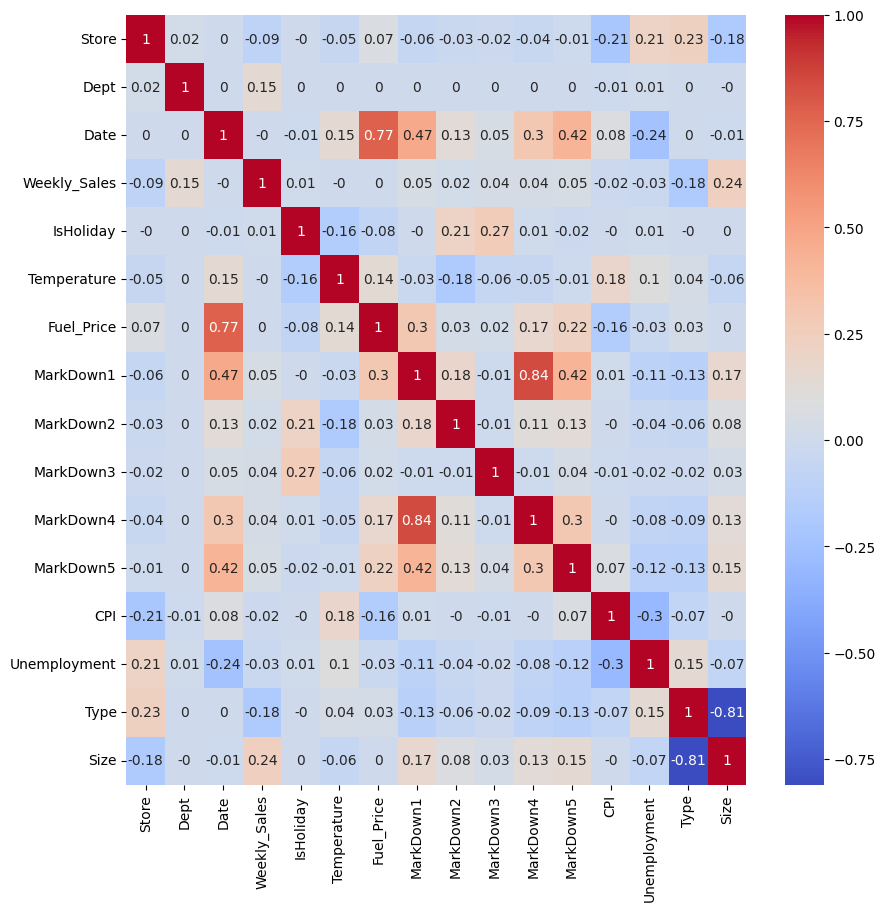

In [ ]:
walmart_data_2 = walmart_data_1

This heatmap presents the Pearson correlation coefficients for various variables, where red suggests a positive correlation, blue indicates a negative one, and white implies no correlation. Stronger intensities denote stronger relationships.

Notably, there's a strong positive correlation between 'Date' and 'FuelPrice' , suggesting that as time progresses, fuel price increases.The negative correlations with 'CPI' and 'Unemployment' suggest that higher consumer prices or unemployment rates might be associated with factors that could negatively impact sales.

Interestingly, 'Store' and 'Dept' seem to have little to no direct relationship with 'Weekly_Sales', which might indicate that sales are not strongly affected by which store or department they are from, within the context of other factors

In [ ]:
# creating dummy variables for Type
type_dummy = pd.get_dummies(walmart_data_1['Type'], prefix='Type', dtype=int)


In [ ]:
# concatenating dummy variables to dataset
walmart_data_1 = pd.concat([walmart_data_1, type_dummy], axis=1)
walmart_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420285 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420285 non-null  int64  
 1   Dept          420285 non-null  int64  
 2   Date          420285 non-null  int64  
 3   Weekly_Sales  420285 non-null  float64
 4   IsHoliday     420285 non-null  int64  
 5   Temperature   420285 non-null  float64
 6   Fuel_Price    420285 non-null  float64
 7   MarkDown1     420285 non-null  float64
 8   MarkDown2     420285 non-null  float64
 9   MarkDown3     420285 non-null  float64
 10  MarkDown4     420285 non-null  float64
 11  MarkDown5     420285 non-null  float64
 12  CPI           420285 non-null  float64
 13  Unemployment  420285 non-null  float64
 14  Type          420285 non-null  int64  
 15  Size          420285 non-null  int64  
 16  Type_1        420285 non-null  int64  
 17  Type_2        420285 non-null  int64  
 18  Type_3   

In [ ]:
store_dummy = pd.get_dummies(walmart_data_1['Store'], prefix='Store', dtype = int)
dept_dummy = pd.get_dummies(walmart_data_1['Dept'], prefix='Dept', dtype=int)
dept_dummy
walmart_data_1 = pd.concat([walmart_data_1, store_dummy,dept_dummy], axis=1)
walmart_data_1

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,1,1,1265328000000000000,24924.50,0,42.31,2.572,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1265328000000000000,50605.27,0,42.31,2.572,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1265328000000000000,13740.12,0,42.31,2.572,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,1265328000000000000,39954.04,0,42.31,2.572,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1265328000000000000,32229.38,0,42.31,2.572,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,1351209600000000000,2487.80,0,58.85,3.882,4018.91,58.08,100.0,...,0,0,0,1,0,0,0,0,0,0
421566,45,94,1351209600000000000,5203.31,0,58.85,3.882,4018.91,58.08,100.0,...,0,0,0,0,1,0,0,0,0,0
421567,45,95,1351209600000000000,56017.47,0,58.85,3.882,4018.91,58.08,100.0,...,0,0,0,0,0,1,0,0,0,0
421568,45,97,1351209600000000000,6817.48,0,58.85,3.882,4018.91,58.08,100.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
walmart_data_1.drop('Type', axis=1, inplace=True)
walmart_data_1.drop('Store', axis=1, inplace=True)
walmart_data_1.drop('Dept', axis=1, inplace=True)


# **Exploratory Data Analysis**

In [ ]:
walmart_data_1

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,1265328000000000000,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
1,1265328000000000000,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,1265328000000000000,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3,1265328000000000000,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,1265328000000000000,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1351209600000000000,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,1,0,0,0,0,0,0
421566,1351209600000000000,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,1,0,0,0,0,0
421567,1351209600000000000,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,0,1,0,0,0,0
421568,1351209600000000000,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,0,0,0,0,0,0,0,1,0,0


# **Univariate Analysis**

<Axes: ylabel='Density'>

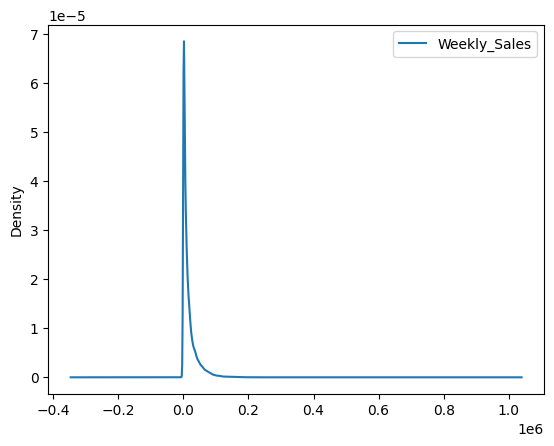

In [ ]:
walmart_data_1[['Weekly_Sales']].plot(kind='kde')

The KDE plot indicates that weekly sales are generally low with a high frequency of weeks showing similar, lower sales values, and a few instances of very high sales.

While looking at the KDE plot, we can infer that the probability of the weekly sales value to lie between 0 to 0.1 is greater than 99%. this can be understood from the area under the curve between 0 to 0.1 .

In [ ]:
walmart_data_1['Weekly_Sales'].skew()

3.259108889879837

Data is highly skewed (right-skewed) and there are so many outliers. We need to scale it down to remove skewness.

<Axes: >

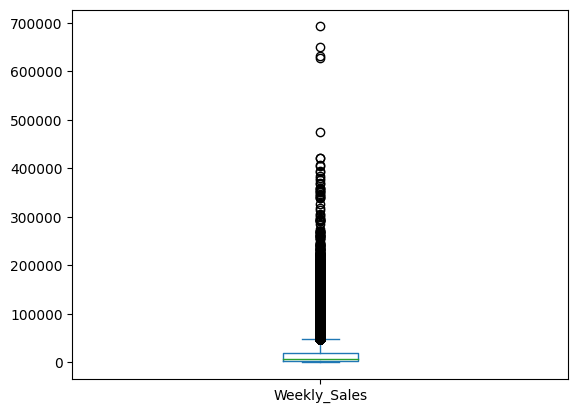

In [ ]:
walmart_data_1['Weekly_Sales'].plot(kind='box')

As mentioned in the KDE plot, we can confirm here that the bottom 95 percentile of the data is contained within the range 0 to 70000 while the top 5 percentile ranges from 70000 to 700000.

In [ ]:
walmart_data_1[walmart_data_1['Weekly_Sales'] > 60000]

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
36,1265328000000000000,115564.35,0,42.31,2.572,0.00,0.0,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
37,1265328000000000000,66780.63,0,42.31,2.572,0.00,0.0,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
56,1265328000000000000,98499.12,0,42.31,2.572,0.00,0.0,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
65,1265328000000000000,76419.47,0,42.31,2.572,0.00,0.0,0.00,0.00,0.00,...,1,0,0,0,0,0,0,0,0,0
66,1265328000000000000,62424.14,0,42.31,2.572,0.00,0.0,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419858,1336089600000000000,65877.07,0,55.21,3.951,11984.62,0.0,47.52,6150.63,1775.54,...,0,0,0,0,0,0,0,0,0,0
419993,1337299200000000000,61519.24,0,66.30,3.848,6813.74,0.0,13.86,936.49,2941.55,...,0,0,0,0,0,0,0,0,0,0
420291,1339718400000000000,60442.84,0,71.93,3.620,8148.19,252.7,90.05,1226.11,2942.39,...,0,0,0,0,0,1,0,0,0,0
420491,1341532800000000000,62606.75,0,82.99,3.475,5878.09,169.0,64.36,2996.47,5477.04,...,0,0,0,0,0,1,0,0,0,0


IsHoliday

<Axes: xlabel='IsHoliday'>

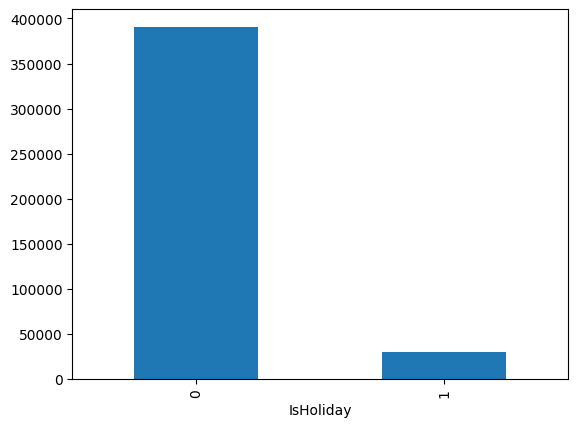

In [ ]:
walmart_data_1['IsHoliday'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

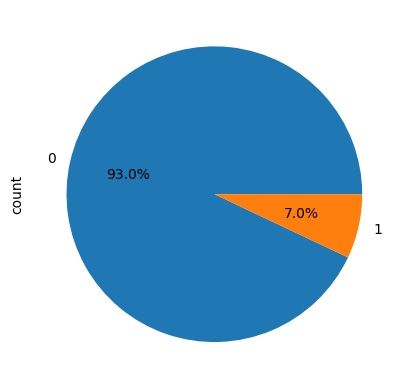

In [ ]:
walmart_data_1['IsHoliday'].value_counts().plot(kind='pie', autopct='%0.1f%%')

Analysis Outcome:

IsHoliday: the count of holidays is much lower than that of workdays.

In [ ]:
walmart_data_1['Temperature'].describe()

count    420285.000000
mean         60.090474
std          18.448260
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64

<Axes: ylabel='Density'>

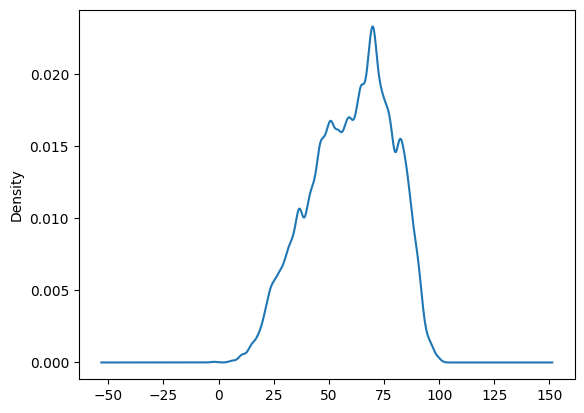

In [ ]:
walmart_data_1['Temperature'].plot(kind='kde')

We can observe that it is evenly distributed with the mean of x and standard deviation od y.

In [ ]:
walmart_data_1['Temperature'].skew()


18.448259690438835

<Axes: >

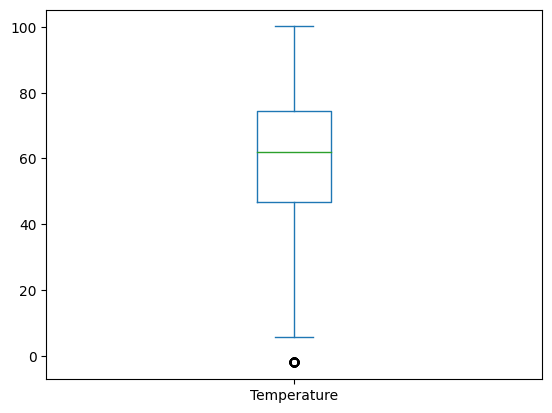

In [ ]:
walmart_data_1['Temperature'].plot(kind='box')

In [ ]:
walmart_data_1[walmart_data_1['Temperature'] < 0]

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
62553,1296777600000000000,8976.04,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
62554,1296777600000000000,21568.46,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
62555,1296777600000000000,7555.18,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
62556,1296777600000000000,15306.89,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
62557,1296777600000000000,12835.06,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62616,1296777600000000000,1170.19,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
62618,1296777600000000000,33881.30,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
62619,1296777600000000000,1412.71,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
62620,1296777600000000000,4601.19,0,-2.06,3.011,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


Analysis Outcome:

Temperature: the data is highly skewed(left) and there is one temperature value that is outlier(-2.06). But that temperature is recorded only at one particular store location (Store = 7)

In [ ]:
walmart_data_1['Fuel_Price'].describe()

count    420285.000000
mean          3.360888
std           0.458523
min           2.472000
25%           2.933000
50%           3.452000
75%           3.738000
max           4.468000
Name: Fuel_Price, dtype: float64

<Axes: ylabel='Density'>

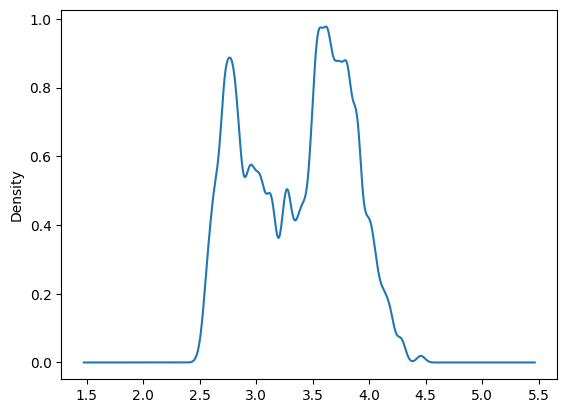

In [ ]:
walmart_data_1['Fuel_Price'].plot(kind='kde')

<Axes: >

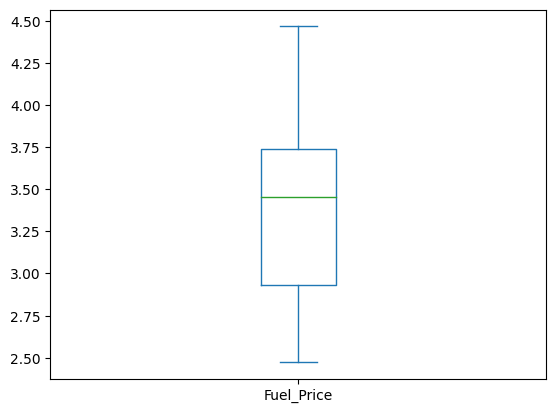

In [ ]:
walmart_data_1['Fuel_Price'].plot(kind='box')

In [ ]:
walmart_data_1['Temperature'].skew()

-0.321259768687628

Analysis Outcome:

Fuel_Price: The data is skewed and there are no outliers.

In [ ]:
walmart_data_1['CPI'].describe()

count    420285.000000
mean        171.212152
std          39.162280
min         126.064000
25%         132.022667
50%         182.350989
75%         212.445487
max         227.232807
Name: CPI, dtype: float64

<Axes: ylabel='Density'>

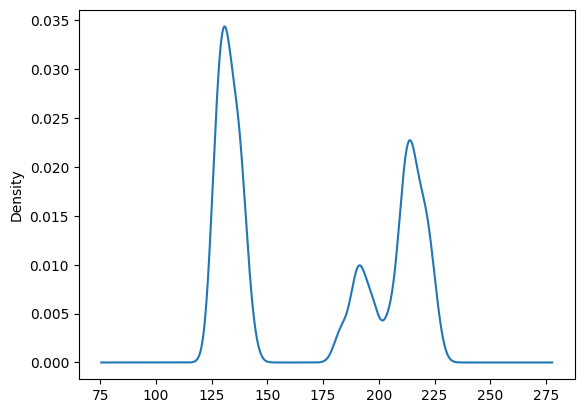

In [ ]:
walmart_data_1['CPI'].plot(kind='kde')

<Axes: >

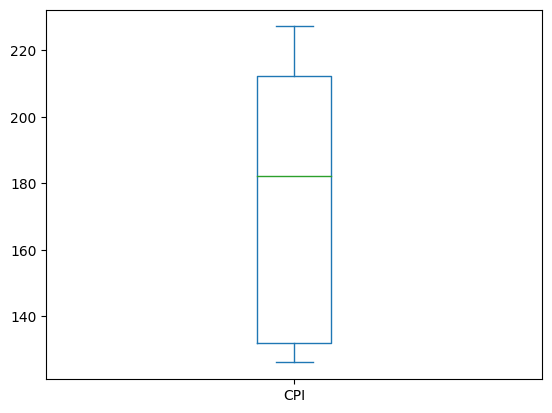

In [ ]:
walmart_data_1['CPI'].plot(kind='box')

In [ ]:
walmart_data_1['CPI'].skew()

0.08467863920365847

Analysis Outcome:

CPI: The data is not highly skewed and there are no outliers.

In [ ]:
walmart_data_1['Unemployment'].describe()

count    420285.000000
mean          7.960077
std           1.863873
min           3.879000
25%           6.891000
50%           7.866000
75%           8.567000
max          14.313000
Name: Unemployment, dtype: float64

<Axes: ylabel='Density'>

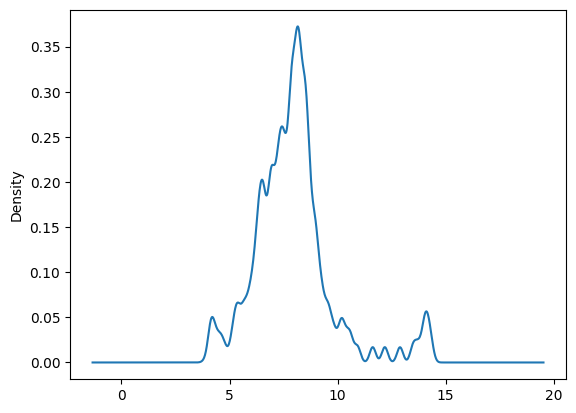

In [ ]:
walmart_data_1['Unemployment'].plot(kind='kde')

<Axes: >

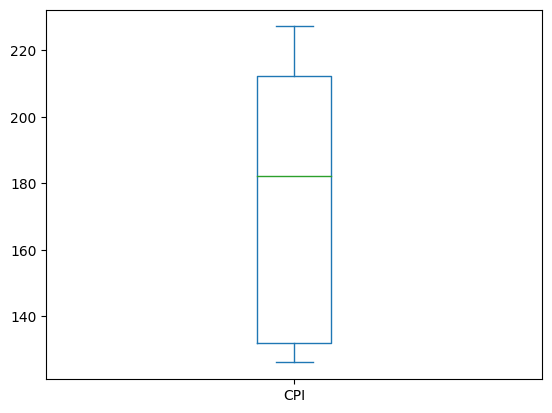

In [ ]:
walmart_data_1['CPI'].plot(kind='box')

In [ ]:
walmart_data_1['Unemployment'].skew()

1.1838441280655663

Analysis Outcome:

Unemployment: The Data is highly skewed and there are no outliers.

In [ ]:
walmart_data_1['Size'].describe()

count    420285.000000
mean     136749.569176
std       60992.688568
min       34875.000000
25%       93638.000000
50%      140167.000000
75%      202505.000000
max      219622.000000
Name: Size, dtype: float64

<Axes: ylabel='Density'>

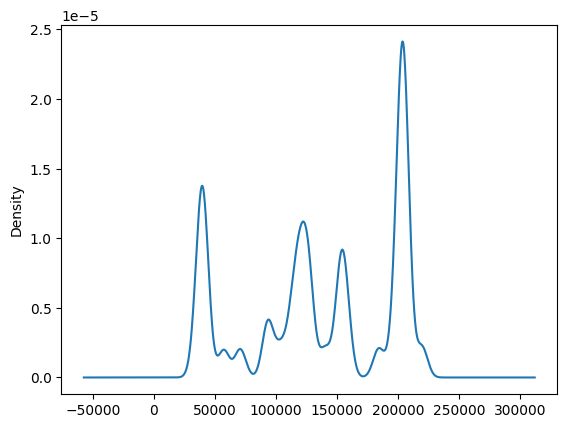

In [ ]:
walmart_data_1['Size'].plot(kind='kde')

<Axes: >

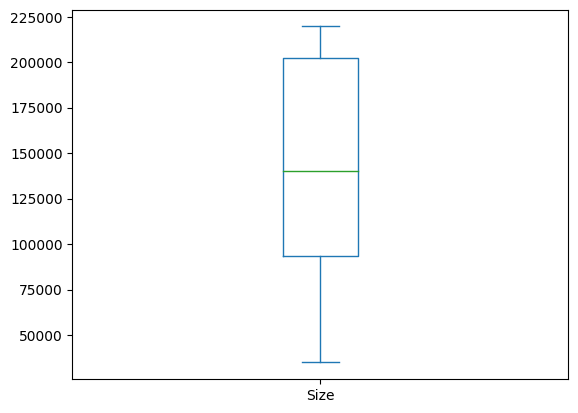

In [ ]:
walmart_data_1['Size'].plot(kind='box')

In [ ]:
walmart_data_1['Size'].skew()

-0.3266745345350833

Analysis Outcome:

Size: the data is highly skewed(positive) and there are no outliers.

Bivariate Analysis

Performing Bivariate Analysis on the column Weekly_Sales with other columns to check their impact on our target variable.

<Axes: >

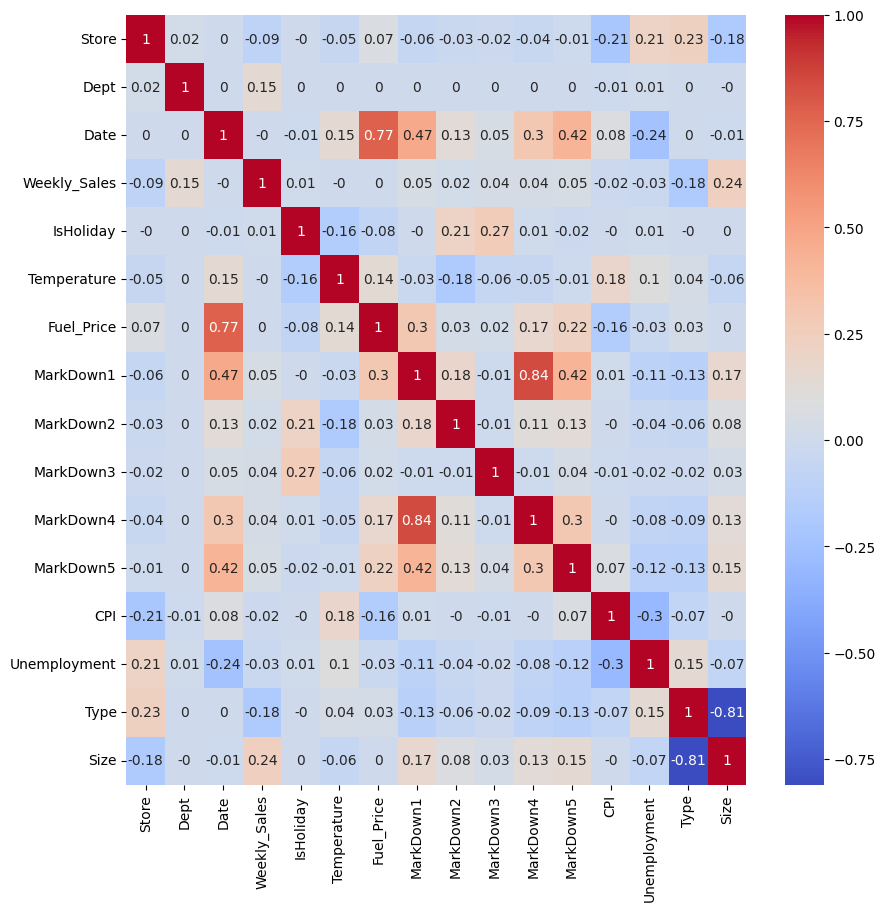

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(walmart_data_2.corr(method='pearson'), 2), cmap="coolwarm", annot=True, ax=ax)

PCA

In [ ]:
y = walmart_data_1['Weekly_Sales']
x = walmart_data_1.drop('Weekly_Sales', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

scaler = StandardScaler()
pca = PCA(n_components=0.95)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#x_train = pca.fit_transform(x_train)
#x_test = pca.transform(x_test)


# **Model Development**

# **Decision Tree**

In [ ]:
model_dt = DecisionTreeRegressor()

model_dt.fit(x_train, y_train)
train_pred = model_dt.predict(x_train)
test_pred = model_dt.predict(x_test)

In [ ]:
print(mean_absolute_error(y_train, train_pred), mean_absolute_error(y_test, test_pred))
print(r2_score(y_train, train_pred), r2_score(y_test, test_pred))

4.058976804491219e-19 2126.368594525144
1.0 0.9311494978510673


MAE:  2126.368594525144
R2:  0.9311494978510673


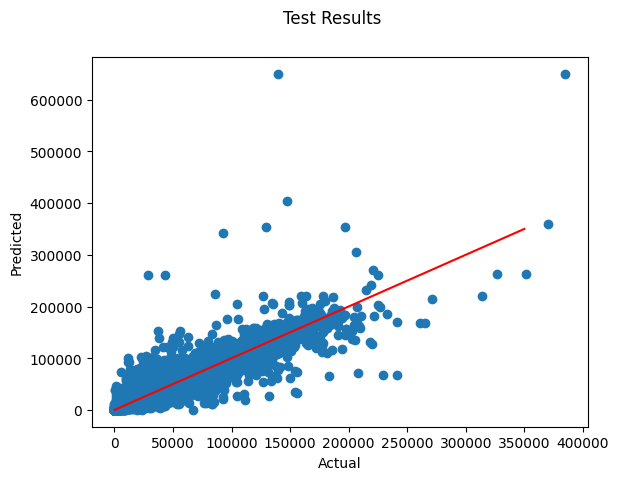

In [ ]:
pred_dt = test_pred # the pred
actual_dt = y_test # the actual
print('MAE: ', mean_absolute_error(y_test, pred_dt))
print('R2: ', r2_score(y_test, pred_dt))
plt.scatter(x=actual_dt, y=pred_dt)
x1 = np.linspace(0,350000) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x1, x1, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The plot shows that the model predicts lower sales quite accurately but struggles with higher values, as predictions deviate more for higher actual sales. The closer the points are to the red line, the better the model's predictions.

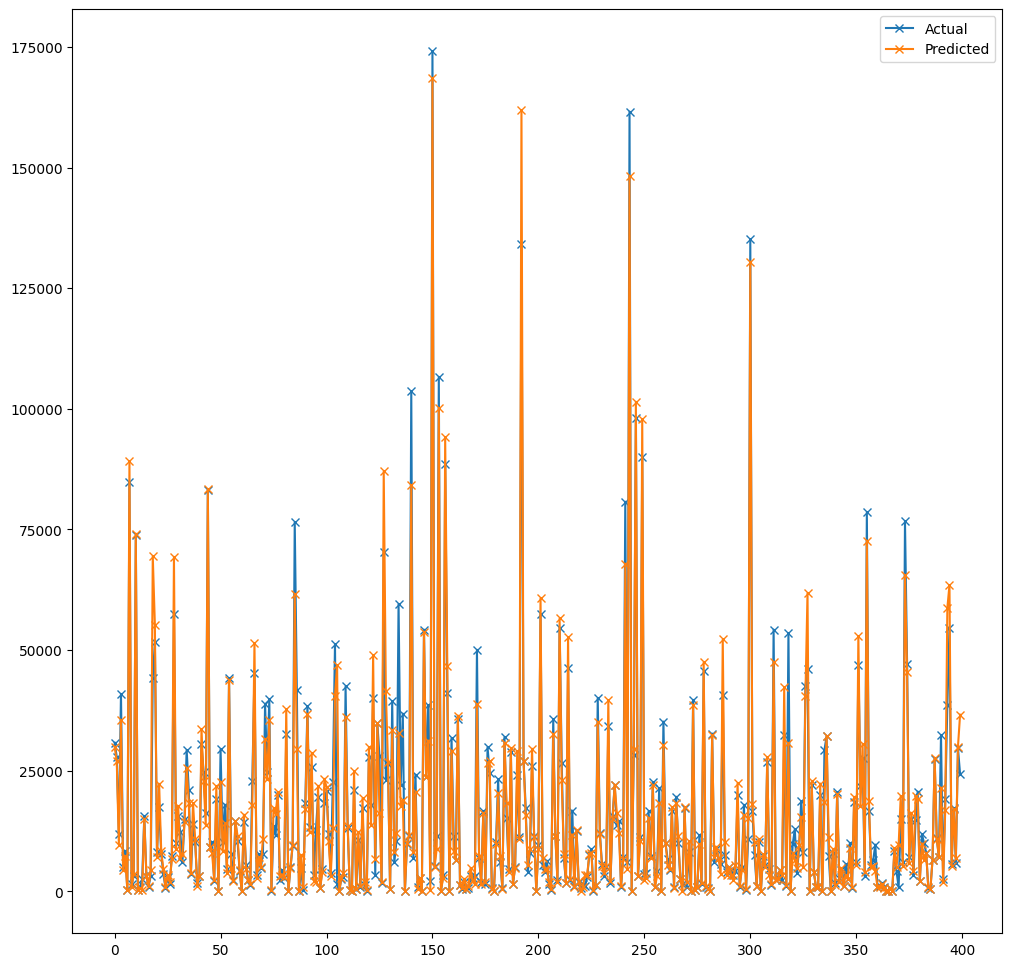

In [ ]:
plt.figure(figsize= (12,12))
plt.plot(np.array(y_test[200:600]), label='Actual', marker = 'x')
plt.plot(test_pred[200:600], label='Predicted',  marker = 'x')
plt.legend()
plt.show()

Frequency Distribution of errors: Tells us the frequency of errors of prediction. Most of the predictions have error close to 0.

The chart is a comparison of actual vs. predicted sales across different data points. The orange line represents predicted sales, and the blue represents actual sales.

The spikes indicate sales figures for each data point. Where the lines are close together, the model's predictions are close to the actual figures. Where they diverge, the predictions are less accurate. It appears there are several points where the prediction significantly differs from the actual sales, indicating potential areas for model improvement.

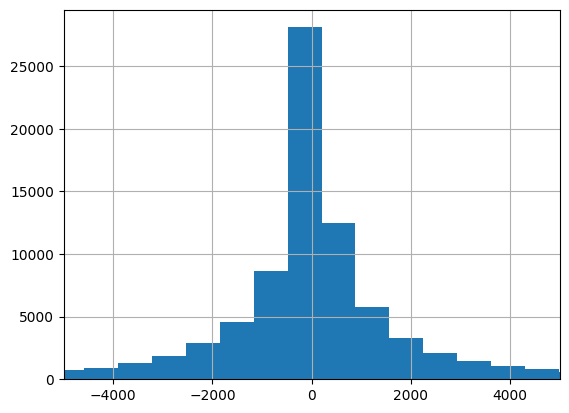

In [ ]:
plt.hist(np.array(y_test)-np.array(test_pred), bins= 1000)
plt.xlim(-5000,5000)
plt.grid()
plt.show()

The histogram shows the errors between the predicted and actual sales are mostly near zero, indicating accurate predictions. There's a symmetrical spread of errors, which suggests no systematic bias in the predictions.

# **Random Forest**

In [ ]:
rf_model = RandomForestRegressor(n_estimators = 20)

rf_model.fit(x_train, y_train)
train_pred = rf_model.predict(x_train)
test_pred = rf_model.predict(x_test)

In [ ]:
print(mean_absolute_error(y_train, train_pred), mean_absolute_error(y_test, test_pred))
print(r2_score(y_train, train_pred), r2_score(y_test, test_pred))

657.3672138296038 1698.8226902637498
0.9933394427680129 0.9620793956624043


MAE:  1698.8226902637498
R2:  0.9620793956624043


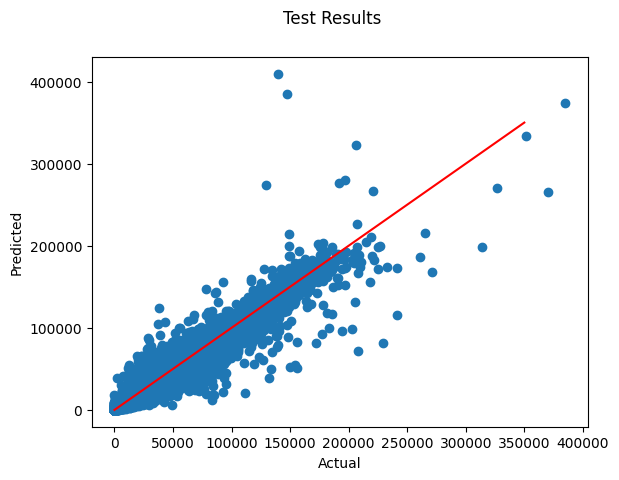

In [ ]:
pred = test_pred # the pred
actual = y_test # the actual
print('MAE: ', mean_absolute_error(y_test, pred))
print('R2: ', r2_score(y_test, pred))
plt.scatter(x=actual, y=pred)
x1 = np.linspace(0,350000) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x1, x1, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The scatter plot shows that for lower actual sales values, the model predicts quite accurately, as indicated by the concentration of points near the red line. For higher sales values, the predictions are more scattered, showing decreased accuracy.

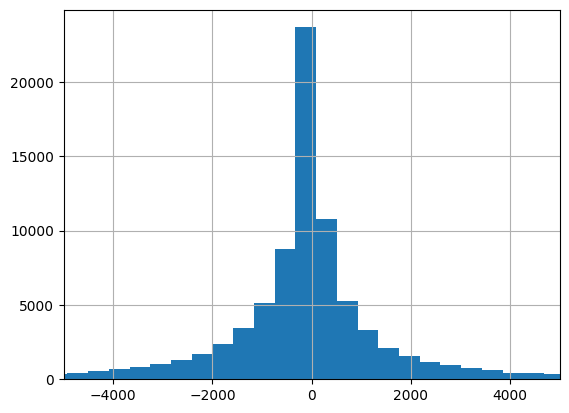

In [ ]:
plt.hist(np.array(y_test)-np.array(test_pred), bins= 1000)
plt.grid()
plt.xlim(-5000,5000)
plt.show()

The histogram illustrates the distribution of the residuals — the differences between the actual and predicted sales. Most residuals cluster around zero, suggesting that the model's predictions are generally accurate, with no clear bias toward over- or under-predicting. The distribution looks normal and centered, indicating good model performance.

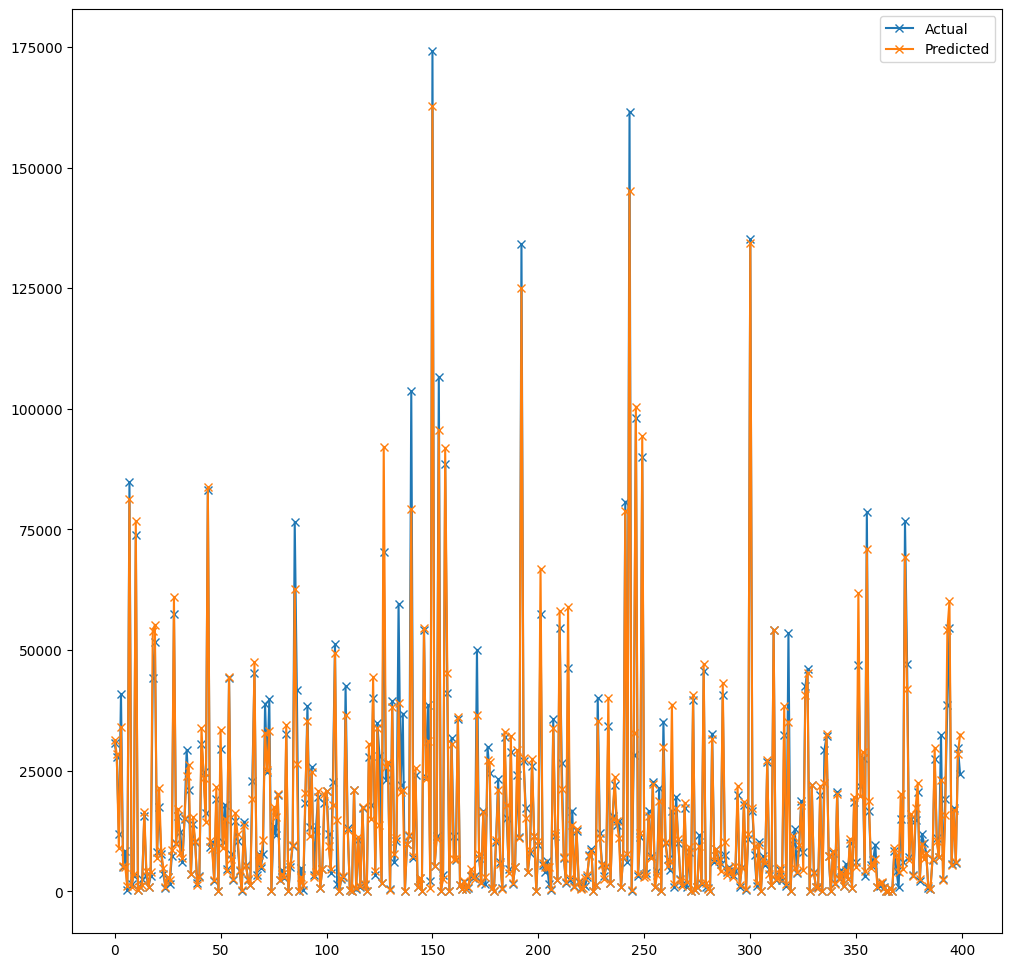

In [ ]:
plt.figure(figsize= (12,12))
plt.plot(np.array(y_test[200:600]), label='Actual', marker = 'x')
plt.plot(test_pred[200:600], label='Predicted',  marker = 'x')
plt.legend()
plt.show()

The plot reveals that the predictions are pretty close to the actual values for many instances, as shown by the overlapping or closely situated crosses. However, there are instances where the prediction significantly underestimates or overestimates the actual figures.

These discrepancies highlight specific points where the predictive model may require further refinement to improve its accuracy.

Overall, the frequent closeness of the actual and predicted values suggests the model has a level of predictive power, but the peaks and troughs indicate it may only consistently capture some of the complexities of the sales data.

# **Neural Network**

In [ ]:
print(y_test.dtype)

float64


In [ ]:
clear_session()
model = Sequential()
model.add(Dense(71, input_shape = (x_train.shape[1], ), activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(35, activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(17, activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(8, activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(4, activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(2, activation = 'leaky_relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation = 'linear'))
model.summary()
model.compile(loss='mae', optimizer='Adam', metrics=['mse'])

# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

history = model.fit(x_train, y_train,
          epochs=10000,
          batch_size=20,
          validation_data=(x_test, y_test),
          verbose=1,
          callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 71)                10082     
                                                                 
 dense_1 (Dense)             (None, 35)                2520      
                                                                 
 dense_2 (Dense)             (None, 17)                612       
                                                                 
 dense_3 (Dense)             (None, 8)                 144       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 dense_6 (Dense)             (None, 1)                 3

In [ ]:
train_pred_nn = model.predict(x_train)
test_pred_nn = model.predict(x_test)

2627/2627 [==============================] - 4s 1ms/step


In [ ]:
print(mean_absolute_error(y_train, train_pred_nn), mean_absolute_error(y_test, test_pred_nn))
print(r2_score(y_train, train_pred_nn), r2_score(y_test, test_pred_nn))

2028.7713459990873 2090.9219088143354
0.9256371982975806 0.9309873992668447


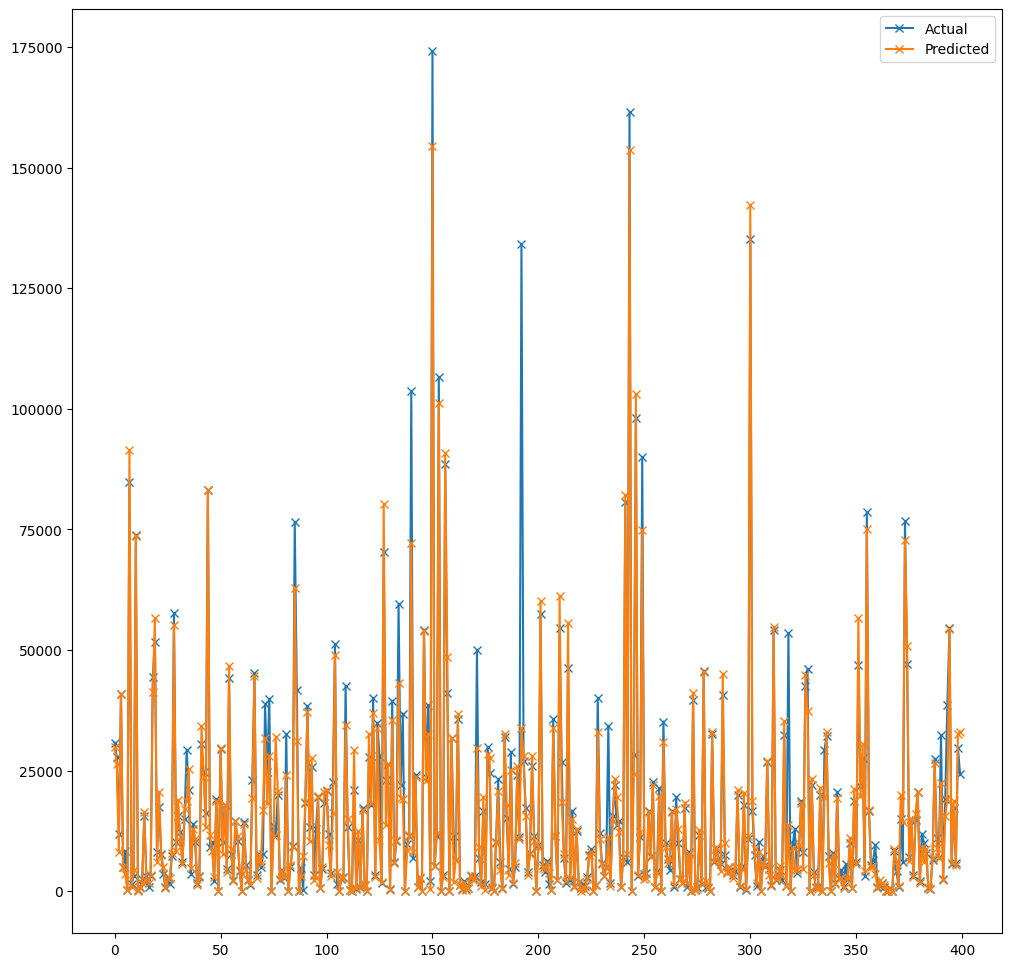

In [ ]:
plt.figure(figsize= (12,12))
plt.plot(np.array(y_test[200:600]), label='Actual', marker = 'x')
plt.plot(test_pred_nn[200:600], label='Predicted',  marker = 'x')
plt.legend()
plt.show()

MAE:  2090.9219088143354
R2:  0.9309873992668447


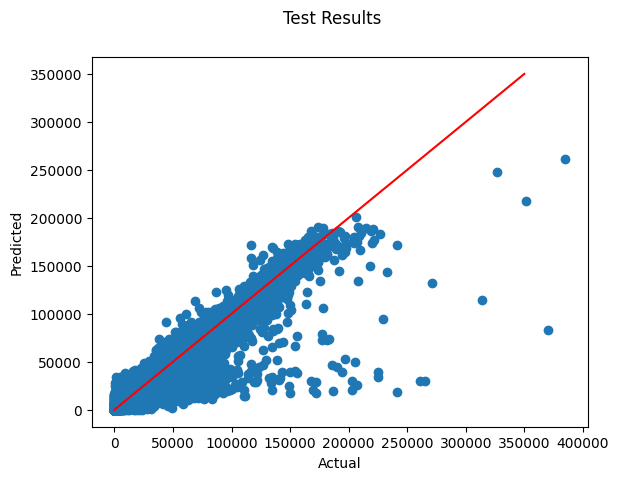

In [ ]:
pred = test_pred_nn # the pred
actual = y_test # the actual
print('MAE: ', mean_absolute_error(y_test, pred))
print('R2: ', r2_score(y_test, pred))
plt.scatter(x=actual, y=pred)
x1 = np.linspace(0,350000) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x1, x1, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Decision tree segments the data into sub-sets and allocates them to their target variable. this makes them resistant to outliers while neural networks are multiple linear regressions interspaced with non-linear function. So, they are more sensitive to outliers.

# **XG Boost**

In [ ]:
boost_model = xgboost.XGBRegressor()
boost_model.fit(x_train, y_train)
train_pred_boost = boost_model.predict(x_train)
test_pred_boost = boost_model.predict(x_test)

In [ ]:
print(mean_absolute_error(y_train, train_pred_boost), mean_absolute_error(y_test, test_pred_boost))
print(r2_score(y_train, train_pred_boost), r2_score(y_test, test_pred_boost))

3305.540714520655 3349.795255612097
0.9339477551163042 0.9310140197110435


MAE:  3349.795255612097
R2:  0.9310140197110435


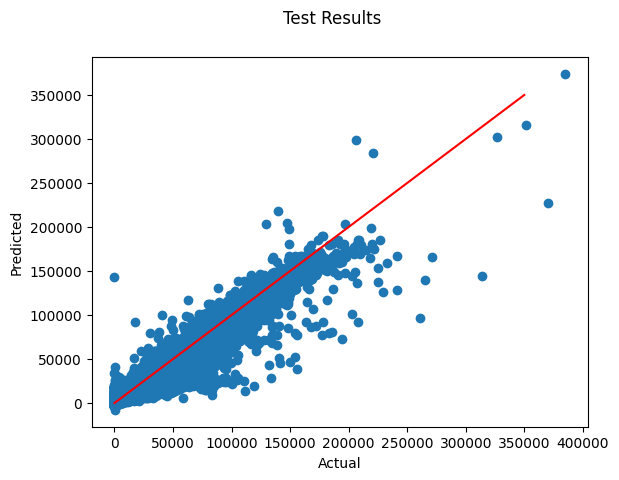

In [ ]:
pred = test_pred_boost # the pred
actual = y_test # the actual
print('MAE: ', mean_absolute_error(y_test, pred))
print('R2: ', r2_score(y_test, pred))
plt.scatter(x=actual, y=pred)
x1 = np.linspace(0,350000) # 45 degree line from 0 to 25 (axes are the same)
plt.plot(x1, x1, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

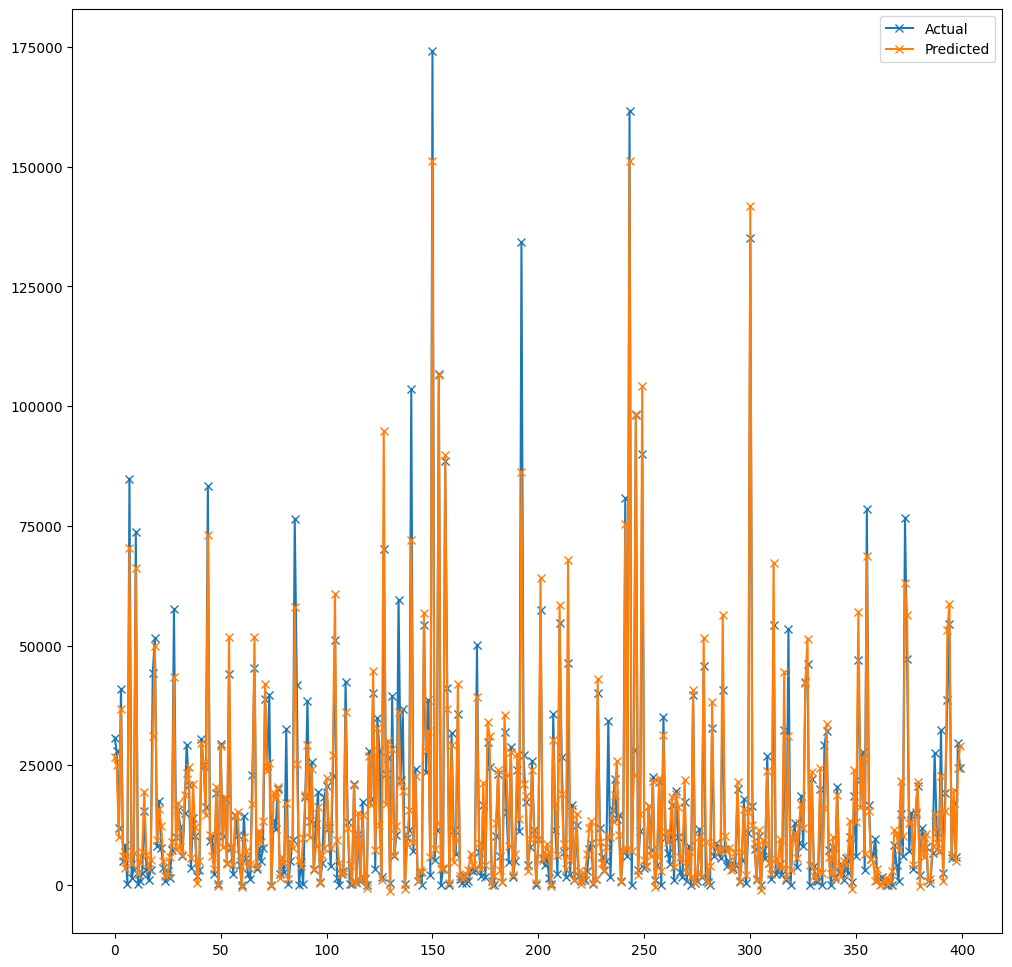

In [ ]:
plt.figure(figsize= (12,12))
plt.plot(np.array(y_test[200:600]), label='Actual', marker = 'x')
plt.plot(test_pred_boost[200:600], label='Predicted',  marker = 'x')
plt.legend()
plt.show()

# **Feature Importance**

In [ ]:
# permutation importance is on X_test

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# let's make this repeatable! all you need to do is assign
# a model object to clf!

clf = rf_model # just update the title!

result = permutation_importance(clf, x_test, y_test, n_repeats=15,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

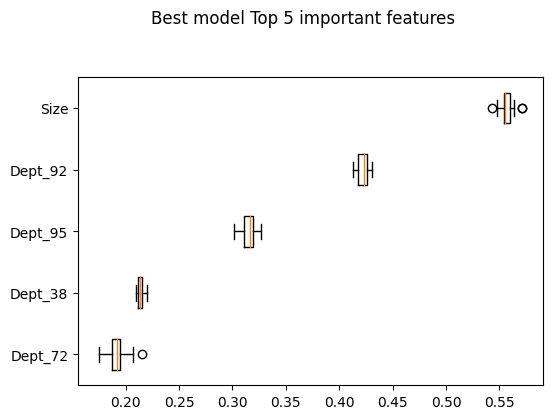

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx[-5:]].T, vert=False,
            labels=x.columns[perm_sorted_idx[-5:]])
fig.suptitle('Best model Top 5 important features', y=1.05)

plt.show()

The plot shows the results of the permutation importance analysis, with the horizontal bars representing the top five features deemed most important by the model for predicting the target variable.

Each horizontal bar corresponds to one feature, and the length of the bar reflects the mean importance of that feature across the repeated permutations. The black lines through the bars denote the range of importance values across the permutations, essentially the variability in the importance measure due to the randomness of the permutation process.


To interpret this within a real-world context, 'Size' likely captures the overall scale of operations at a store, which naturally would affect sales volumes. The specific department features could indicate that sales in these departments are significant contributors to overall sales, or that promotions or seasonal effects within these departments are strong predictors of the target variable.